Learning rate = 0.01
epoch 15
Optimizer = Adam
Model - MobileNet
images - rgb with full range value without normalization
three layes added at top - dense(1000), dropout, dense

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import PIL
import os

import matplotlib.pylab as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_dir = pathlib.Path("./final_dataset/")
data_dir

PosixPath('final_dataset')

# Preprocessing

## Read image files

In [3]:
from matplotlib import path
data_images_dict = {
    'Mask': list(data_dir.glob('**/mask/*')),
    'Improper Mask': list(data_dir.glob('**/improper_mask/*')),
    'Non Mask': list(data_dir.glob('**/no_mask/*'))
}

In [4]:
data_labels_dict = {
    'Mask': 0,
    'Improper Mask': 1,
    'Non Mask': 2
}

## Image to CSV

In [5]:
X, y = [], []

for image_name, images in data_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(data_labels_dict[image_name])

In [6]:
X = np.array(X)
y = np.array(y)

# Visualization

# Model training

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [9]:
IMAGE_SHAPE=(224,224)

In [10]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

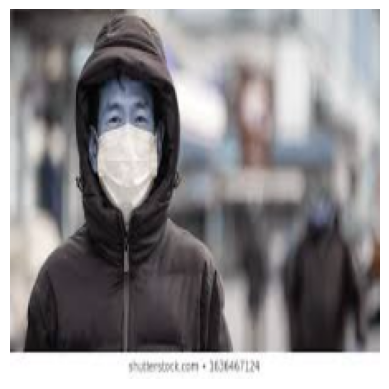

In [11]:
plt.axis('off')
plt.imshow(X[500])

In [12]:
pretrained_model_without_top_layer = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),include_top=False, weights='imagenet',
    input_tensor=None, pooling="avg")

In [13]:
for layers in pretrained_model_without_top_layer.layers:
  layers.trainable = False

In [14]:
num_of_classes = 3

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(1000),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0

In [15]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.000001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [16]:
weight_dir = "weights/50_epoch_Resnet50"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [ ]:
# history = model.fit(X_train_scaled, y_train, epochs=15,initial_epoch=11,callbacks=[checkpoint])
history = model.fit(X_train_scaled, y_train, epochs=50,callbacks=[checkpoint],validation_split=0.20,batch_size=10)

Epoch 1/50


2022-12-07 12:43:41.228576: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


573/573 [==============================] - 294s 505ms/step - loss: 1.4658 - acc: 0.3906 - val_loss: 1.2658 - val_acc: 0.4330
Epoch 2/50
573/573 [==============================] - 318s 555ms/step - loss: 1.3284 - acc: 0.4243 - val_loss: 1.1299 - val_acc: 0.5175
Epoch 3/50
573/573 [==============================] - 366s 639ms/step - loss: 1.2488 - acc: 0.4472 - val_loss: 1.0555 - val_acc: 0.5489
Epoch 4/50
573/573 [==============================] - 385s 672ms/step - loss: 1.2143 - acc: 0.4823 - val_loss: 0.9456 - val_acc: 0.6054
Epoch 5/50
573/573 [==============================] - 463s 808ms/step - loss: 1.1768 - acc: 0.4948 - val_loss: 0.9896 - val_acc: 0.5754
Epoch 6/50
573/573 [==============================] - 412s 720ms/step - loss: 1.1585 - acc: 0.4989 - val_loss: 0.9627 - val_acc: 0.5943
Epoch 7/50
573/573 [==============================] - 353s 617ms/step - loss: 1.1472 - acc: 0.5142 - val_loss: 0.9354 - val_acc: 0.5943
Epoch 8/50
573/573 [==============================] - 384s 

In [1]:
history.history

NameError: name 'history' is not defined

In [ ]:
model.evaluate(X_test_scaled,y_test)

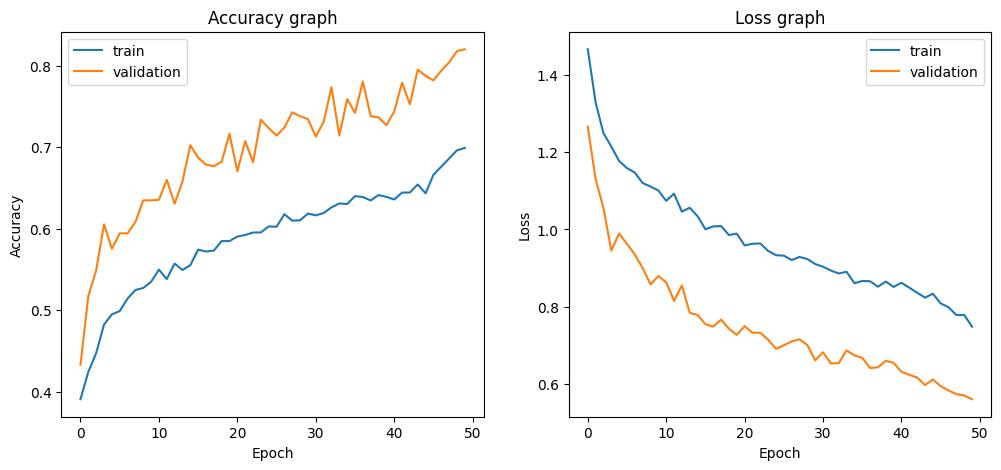

In [25]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
axs[0].plot(resnet50_history['accuracy'])
axs[0].plot(resnet50_history['val_accuracy'])
axs[0].set_title('Accuracy graph')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['train','validation'])

axs[1].plot(resnet50_history['loss'])
axs[1].plot(resnet50_history['val_loss'])
axs[1].set_title('Loss graph')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['train','validation'])

plt.show()

In [ ]:
model.predict(X_test_scaled[0].reshape(1,224,224,3))

In [ ]:
plt.imshow(X_test[0])

In [ ]:
y_test[0]

In [ ]:
type(history)

In [ ]:
h = pd.DataFrame(history.history)

In [ ]:
h.to_csv('history_resnet50_50_epoch.csv')